In [ ]:
!pip install pyfastx

     |████████████████████████████████| 870kB 2.9MB/s 


In [ ]:
import networkx as nx
import pyfastx as fx
from tqdm import tqdm
import numpy as np
import pandas as pd
import json
import pydot
from copy import deepcopy
from collections import defaultdict
from collections import Counter
from IPython.display import Image

In [ ]:
cd drive/MyDrive/ngs_5/

/content/drive/MyDrive/ngs_5


In [ ]:
class DBG:
    
    def __init__(self, path, k):
        self.reads = fx.Fastx(path)
        self.k = k
        self.k_coverage = defaultdict(int)
        self.comp_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
        
        
    def comp_seq(self, seq):
        return ''.join([self.comp_dict[base] for base in seq[::-1]])
    
    
    def create_graph(self):
        graph = nx.DiGraph()
        for read in self.reads:
            seq = read[1]
            for i in range(len(seq)-self.k):
                
                #добавление пары k-меров в общий граф
                node_1 = seq[i:i+self.k]
                node_2 = seq[i+1:i+1+self.k]
                self.k_coverage[node_1] += 1
                graph.add_edge(node_1, node_2)
                
                #добавление пары комплементарных k-меров в общий граф
                comp_node_1 = self.comp_seq(node_2)
                comp_node_2 = self.comp_seq(node_1)
                self.k_coverage[comp_node_2] += 1
                graph.add_edge(comp_node_1, comp_node_2)
            
            #учёт последних k-меров
            self.k_coverage[node_2] += 1
            self.k_coverage[comp_node_1] += 1
        
        self.kmers = np.unique(np.array(graph.edges).flatten())
        self.kmers_ind = {}
        for i, kmer in enumerate(self.kmers):
            self.kmers_ind[kmer] = i
        self.adj_list = [[] for _ in range(len(self.kmers))]
        for edge in graph.edges:
            self.adj_list[self.kmers_ind[edge[0]]].append(self.kmers_ind[edge[1]])
        
    
    def create_edges(self):
        self.edges = {}
        for ind_1, n_1 in enumerate(self.adj_list):
            in_kmer = self.kmers[ind_1]
            for ind_2 in n_1:
                out_kmer = self.kmers[ind_2]
                self.edges[(ind_1, ind_2)] = in_kmer + out_kmer[-1]
                self.k_coverage[in_kmer + out_kmer[-1]] = (self.k_coverage[in_kmer] + self.k_coverage[out_kmer])/2
                
    
    
    def compress_graph(self):
        len_edges = len(self.edges)
        while True:
            for node_ind, node in enumerate(self.adj_list):
                if len(node) == 1 and node[0] != -1:
                    node_in_ind = None
                    node_out_ind = node[0]
                    count = 0
                    flag = False
                    for sub_node_ind, sub_node in enumerate(self.adj_list):
                        if node_ind in sub_node:
                            count += 1
                            if count == 1 and flag == False:
                                flag = True
                                node_in_ind = sub_node_ind
                            elif count > 1:
                                node_in_ind = None
                                break
                    if not node_in_ind is None:
                        self.adj_list[node_ind][0] = -1
                        self.adj_list[node_in_ind] = [i if i != node_ind else node_out_ind for i in self.adj_list[node_in_ind]]
                        self.edges[(node_in_ind, node_out_ind)] = self.edges[(node_in_ind, node_ind)][:-self.k] + self.edges[(node_ind, node_out_ind)]
                        self.k_coverage[self.edges[(node_in_ind, node_out_ind)]] = (self.k_coverage[self.edges[(node_in_ind, node_ind)]] + self.k_coverage[self.edges[(node_ind, node_out_ind)]])/2
                        #del self.edges[(node_in_ind, node_ind)]
                        #del self.edges[(node_ind, node_out_ind)]
                        #break
            if len_edges != len(self.edges):
                #print(len_edges)
                len_edges = len(self.edges)
            else:
                self.adj_list = np.array([np.array(node) for node in self.adj_list])
                break

    
    def compress_graph_old(self):
        self.np_matrix_columns = np.array(self.matrix.columns)
        self.matrix = np.array(self.matrix)
        n_edges = self.edges.shape[0]
        while True:
            for node_ind in range(self.np_matrix_columns.shape[0]):
                n_in = np.sum(self.matrix[:, node_ind])
                n_out = np.sum(self.matrix[node_ind, :])
                if n_in == n_out == 1:
                    node = self.np_matrix_columns[node_ind]
                    node_in_ind = np.argmax(self.matrix[:, node_ind])
                    node_in = self.np_matrix_columns[node_in_ind]
                    node_out_ind = np.argmax(self.matrix[node_ind, :])
                    node_out = self.np_matrix_columns[node_out_ind]
                    self.matrix[node_in_ind, node_out_ind] += 1
                    self.matrix = np.delete(self.matrix, node_ind, axis=0)
                    self.matrix = np.delete(self.matrix, node_ind, axis=1)
                    self.np_matrix_columns = np.delete(self.np_matrix_columns, node_ind, axis=0)
                    in_edge = self.edges[(self.edges['n_1'] == node_in) & ((self.edges['n_2'] == node))]['edge'].values[0]
                    out_edge = self.edges[(self.edges['n_1'] == node) & ((self.edges['n_2'] == node_out))]['edge'].values[0]
                    new_edge = in_edge[:-self.k] + out_edge
                    self.k_coverage[new_edge] = (self.k_coverage[in_edge] + self.k_coverage[out_edge])/2
                    self.edges = self.edges[(self.edges['edge'] != in_edge) & (self.edges['edge'] != out_edge)]
                    self.edges.reset_index(drop=True, inplace=True)
                    self.edges.loc[self.edges.shape[0]] = [node_in, node_out, new_edge]
                    break
                else:
                    continue
            if n_edges != self.edges.shape[0]:
                n_edges = self.edges.shape[0]
            else:
                self.matrix = pd.DataFrame(self.matrix, index=self.np_matrix_columns, columns=self.np_matrix_columns)
                break


    
    
    def mean_cov(self, edge):
        return self.k_coverage[edge]
        
        
        
        
    def add_meta_data(self):
        for key in self.edges.keys():
            self.edges[key] = [self.edges[key], round(len(self.edges[key])/self.k, 1), round(self.k_coverage[self.edges[key]], 1)]


    def add_meta_data_old(self):
        self.edges['L'] = self.edges['edge'].apply(len)
        self.edges['L'] = round(self.edges['L']/self.k, 1)
        self.edges['cov'] = self.edges['edge'].apply(lambda edge: self.mean_cov(edge))
        
    
    def to_pandas_matrix(self):
        nodes = []
        for i, nb in enumerate(self.adj_list):
            if (len(nb) != 0) and (nb[0] != -1) and (self.kmers[i] not in nodes):
                nodes.append(self.kmers[i])
            for node in nb:
                if (node != -1) and (self.kmers[node] not in nodes):
                    nodes.append(self.kmers[node])
        self.matrix = pd.DataFrame(0, index=nodes, columns=nodes)
        for s, row in self.matrix.iterrows():
            for t, edge in enumerate(row):
                if self.kmers_ind[nodes[t]] in self.adj_list[self.kmers_ind[s]]:
                    row[t] = 1
        edges_ind = np.where(self.matrix == 1)
        edges = pd.DataFrame(0, index=range(len(edges_ind[0])), columns=['n_1', 'n_2', 'edge', 'L', 'cov'])
        count = 0
        for i, edge in edges.iterrows():
            edges.iloc[i,0] = nodes[edges_ind[0][count]]
            edges.iloc[i,1] = nodes[edges_ind[1][count]]
            edges.iloc[i,2] = self.edges[(self.kmers_ind[edges.iloc[i, 0]], self.kmers_ind[edges.iloc[i, 1]])][0]
            edges.iloc[i,3] = self.edges[(self.kmers_ind[edges.iloc[i, 0]], self.kmers_ind[edges.iloc[i, 1]])][1]
            edges.iloc[i,4] = self.edges[(self.kmers_ind[edges.iloc[i, 0]], self.kmers_ind[edges.iloc[i, 1]])][2]
            count += 1
        self.edges = deepcopy(edges)


    
    def discard_tips(self, min_cov, min_len):
        for node in self.matrix.columns:
            n_in = np.sum(self.matrix.loc[:, node])
            n_out = np.sum(self.matrix.loc[node, :])
            if n_in + n_out == 1:
                edge = self.edges[(self.edges['n_1'] == node) | (self.edges['n_2'] == node)]
                if edge['L'].values[0] < min_len or edge['cov'].values[0] < min_cov:
                    self.matrix.drop(node, axis=0, inplace=True)
                    self.matrix.drop(node, axis=1, inplace=True)
                    self.edges = self.edges[~((self.edges['n_1'] == node) | (self.edges['n_2'] == node))]
                    self.edges.reset_index(drop=True, inplace=True)
        

    
    def discard_all_bad(self, min_cov, min_len):
        n_edges = self.edges.shape[0]
        while True:
            for i, edge in self.edges.iterrows():   
                if edge['L'] < min_len or edge['cov'] < min_cov:
                    self.matrix.loc[edge['n_1'], edge['n_2']] -= 1
                    self.edges.drop(index=i, inplace=True)
                    self.edges.reset_index(drop=True, inplace=True)
                    break
                else:
                    continue
            if n_edges != self.edges.shape[0]:
                n_edges = self.edges.shape[0]
            else:
                break
        
    
    
    def write_in_dot(self, dot_file_path, nodes_file_path):
        with open(dot_file_path, "w") as dot_file:
            dot_file.write("digraph {\n")
            nodes = set(self.edges['n_1'].values) | set(self.edges['n_2'].values)
            node_id = {node: i for i, node in enumerate(nodes)}
            json.dump(dict(enumerate(nodes)), open(nodes_file_path, "w"))
            for node in nodes:
                dot_file.write(f"{node_id[node]};\n")
            for i, (n_1, n_2) in enumerate(zip(self.edges['n_1'], self.edges['n_2'])):
                label = f" L:{self.edges['L'][i]}k\n cov:{self.edges['cov'][i]:.1f}"
                dot_file.write(f"""{node_id[n_1]} -> {node_id[n_2]} [label="{label}"];\n""") 
            dot_file.write("}")


    def dot_to_png(self, dot_file_path, png_file_path):
        (graph,) = pydot.graph_from_dot_file(dot_file_path)
        graph.write_png(png_file_path)


    def edges_to_fasta(self, fasta_file_path):
        with open(fasta_file_path, "w") as fasta_file:
            for i, row in self.edges.iterrows():
                title = f"> {row['n_1']} -> {row['n_2']} | Len:{row['L']};Cov:{row['cov']:.1f}"
                seq = row['edge']
                fasta_file.write(f"{title}\n{seq}\n")

# s_6_1k



In [ ]:
path = 's_6.first1000.fastq.gz'
dbg = DBG(path, 55)
dbg.create_graph()
dbg.create_edges()
dbg.compress_graph()
dbg.add_meta_data()
dbg.to_pandas_matrix()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


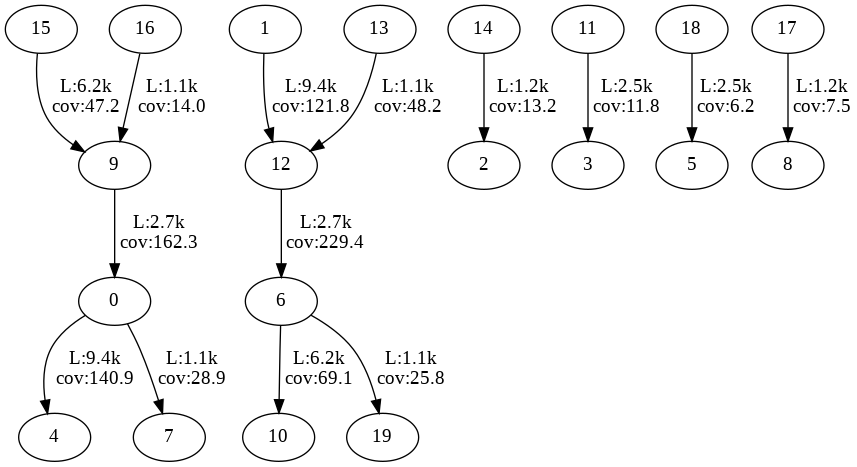

In [ ]:
dbg.write_in_dot('new_1k.dot', 'new_1k.json')
dbg.dot_to_png('new_1k.dot', 'new_1k.png')
Image('new_1k.png')

In [ ]:
matrix = deepcopy(dbg.matrix)
edges = deepcopy(dbg.edges)

In [ ]:
dbg.discard_tips(30, 2)

In [ ]:
dbg.edges.drop('L', axis=1, inplace=True)
dbg.edges.drop('cov', axis=1, inplace=True)

In [ ]:
dbg.compress_graph_old()

In [ ]:
dbg.add_meta_data_old()

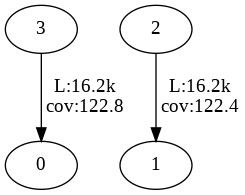

In [ ]:
dbg.write_in_dot('new_1k_tips.dot', 'new_1k_tips.json')
dbg.dot_to_png('new_1k_tips.dot', 'new_1k_tips.png')
Image('new_1k_tips.png')

In [ ]:
dbg.matrix = matrix
dbg.edges = edges

In [ ]:
dbg.discard_all_bad(30, 2)
dbg.edges.drop('L', axis=1, inplace=True)
dbg.edges.drop('cov', axis=1, inplace=True)
dbg.compress_graph_old()
dbg.add_meta_data_old()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


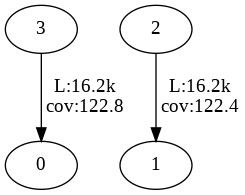

In [ ]:
dbg.write_in_dot('new_1k_allbad.dot', 'new_1k_allbad.json')
dbg.dot_to_png('new_1k_allbad.dot', 'new_1k_allbad.png')
Image('new_1k_allbad.png')

# s_6_10k

In [ ]:
path = 's_6.first10000.fastq.gz'
dbg = DBG(path, 55)
dbg.create_graph()
dbg.create_edges()
dbg.compress_graph()
dbg.add_meta_data()
dbg.to_pandas_matrix()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


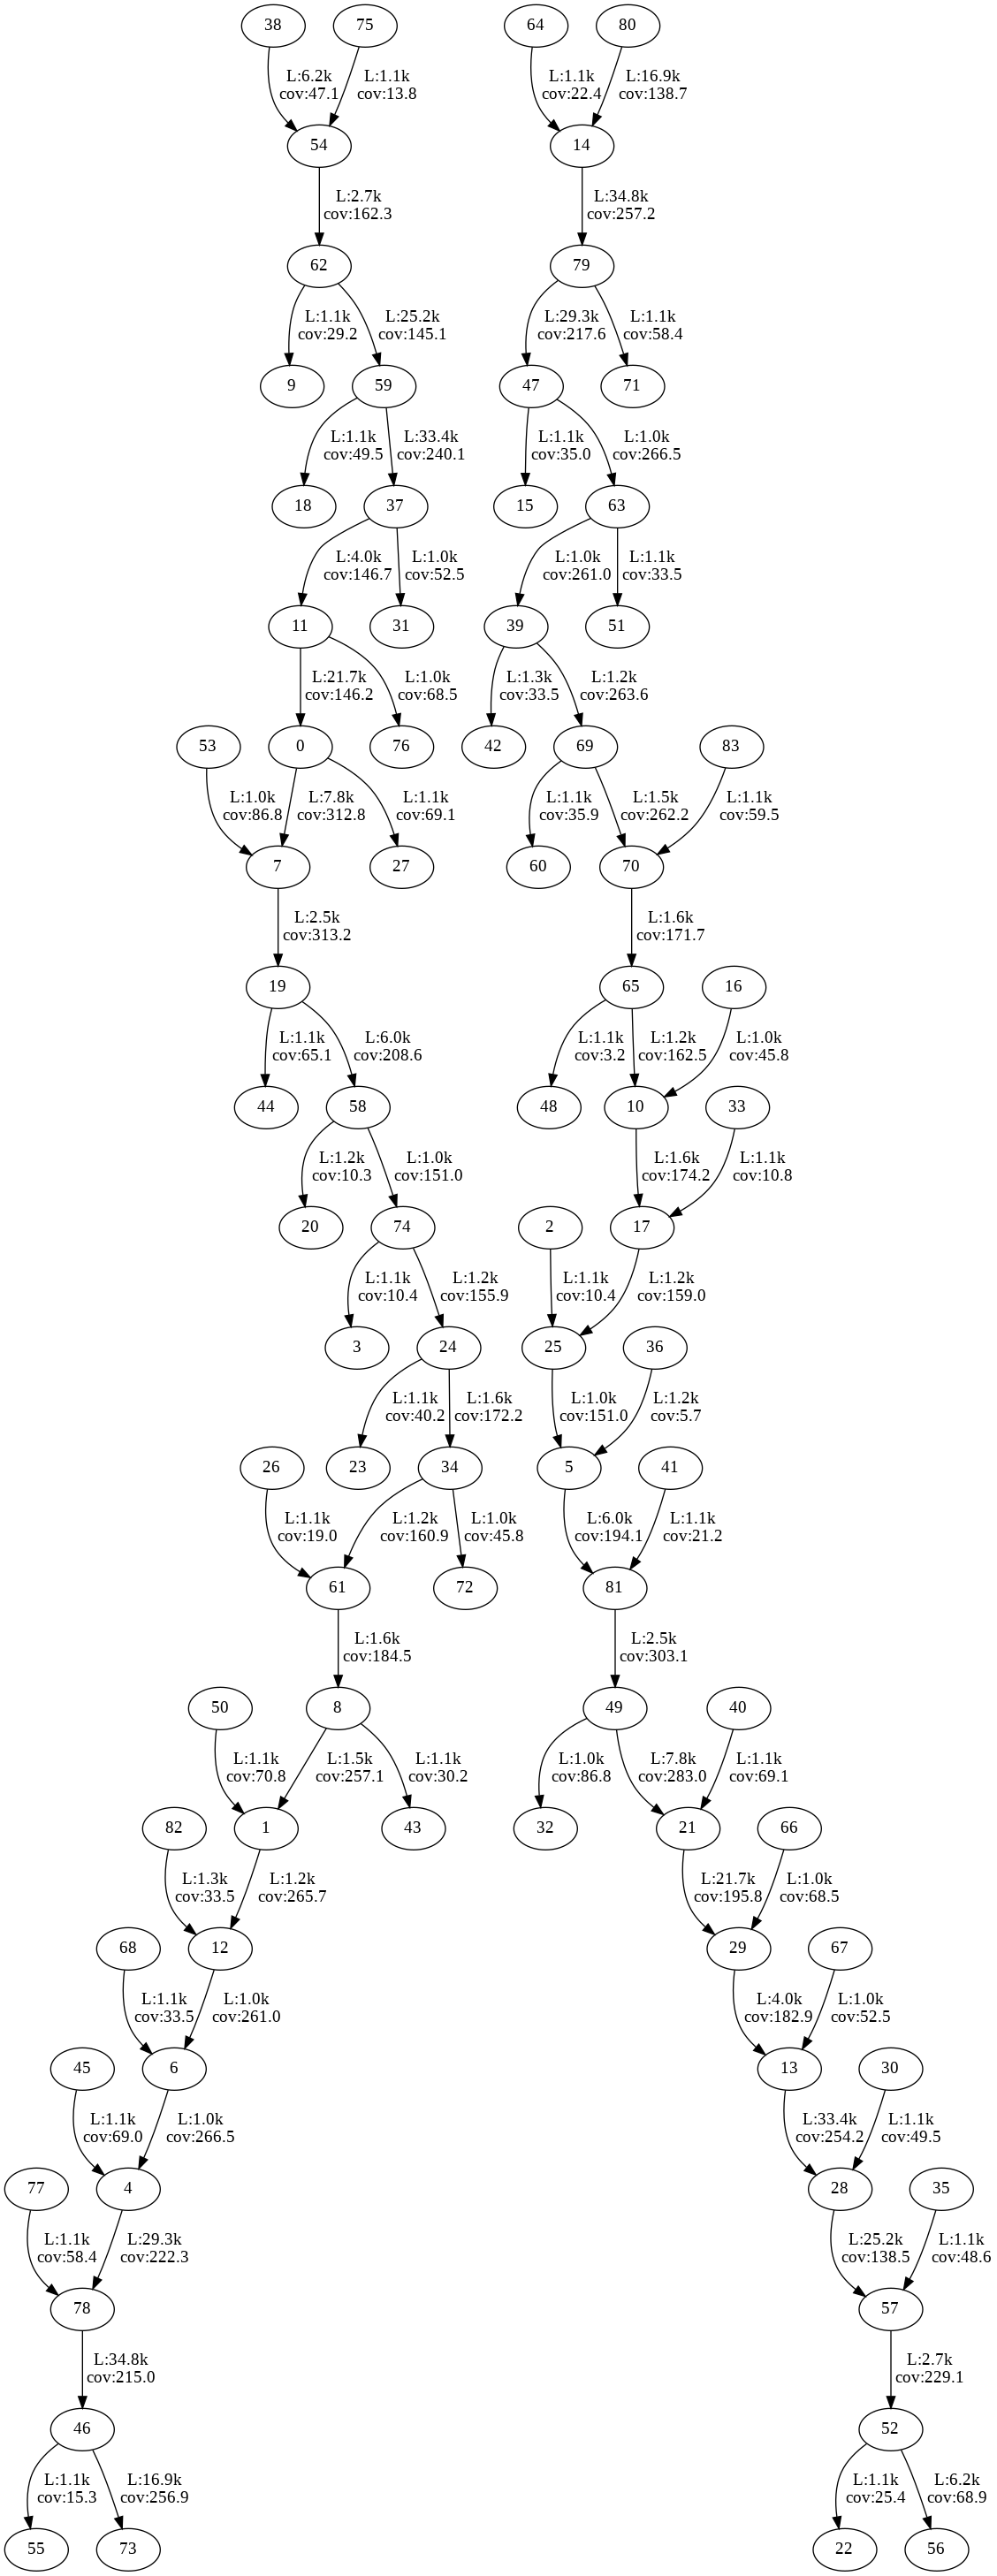

In [ ]:
dbg.write_in_dot('new_10k.dot', 'new_10k.json')
dbg.dot_to_png('new_10k.dot', 'new_10k.png')
Image('new_10k.png')

In [ ]:
matrix = deepcopy(dbg.matrix)
edges = deepcopy(dbg.edges)

In [ ]:
dbg.discard_tips(50, 2)
dbg.edges.drop('L', axis=1, inplace=True)
dbg.edges.drop('cov', axis=1, inplace=True)
dbg.compress_graph_old()
dbg.add_meta_data_old()

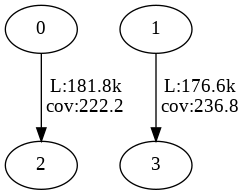

In [ ]:
dbg.write_in_dot('new_10k_tips.dot', 'new_10k_tips.json')
dbg.dot_to_png('new_10k_tips.dot', 'new_10k_tips.png')
Image('new_10k_tips.png')

In [ ]:
dbg.matrix = matrix
dbg.edges = edges

In [ ]:
dbg.discard_all_bad(50, 2)
dbg.edges.drop('L', axis=1, inplace=True)
dbg.edges.drop('cov', axis=1, inplace=True)
dbg.compress_graph_old()
dbg.add_meta_data_old()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


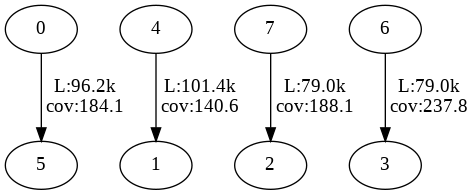

In [ ]:
dbg.write_in_dot('new_10k_allbad.dot', 'new_10k_allbad.json')
dbg.dot_to_png('new_10k_allbad.dot', 'new_10k_allbad.png')
Image('new_10k_allbad.png')

# s_6_100k

In [ ]:
path = 's_6.first100000.fastq.gz'
dbg = DBG(path, 55)
dbg.create_graph()
dbg.create_edges()
dbg.compress_graph()
dbg.add_meta_data()
dbg.to_pandas_matrix()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
dbg.write_in_dot('new_100k.dot', 'new_100k.json')
dbg.dot_to_png('new_100k.dot', 'new_100k.png')
Image('new_100k.png')

In [205]:
matrix = deepcopy(dbg.matrix)
edges = deepcopy(dbg.edges)

In [206]:
dbg.discard_tips(50, 2)
dbg.edges.drop('L', axis=1, inplace=True)
dbg.edges.drop('cov', axis=1, inplace=True)
dbg.compress_graph_old()
dbg.add_meta_data_old()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


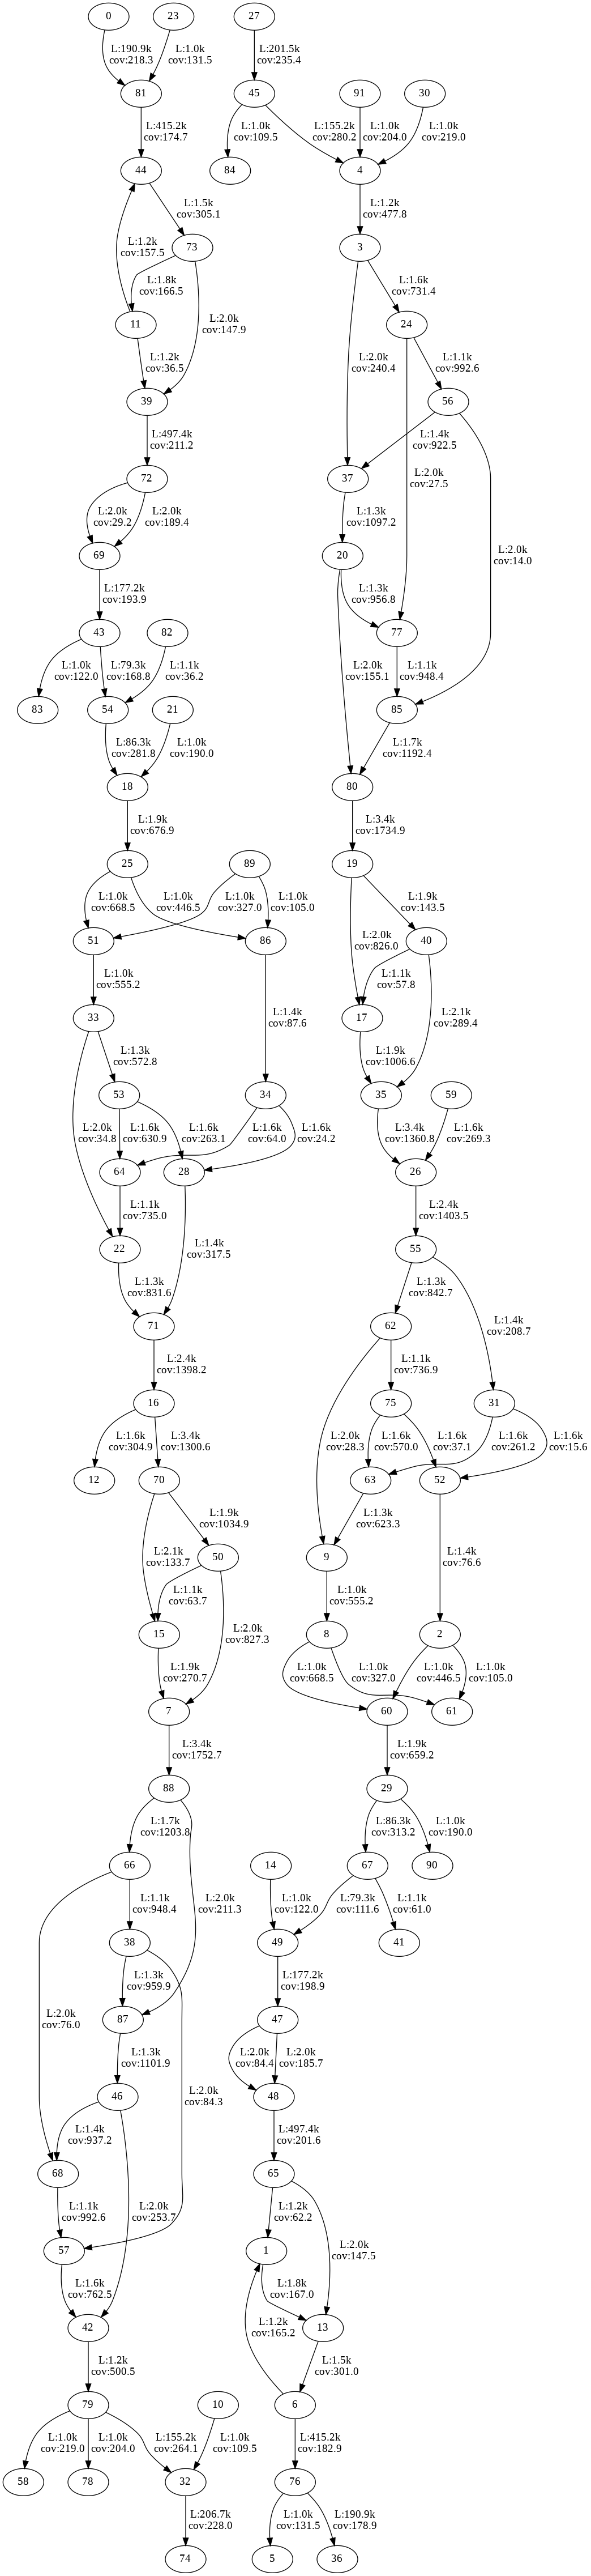

In [207]:
dbg.write_in_dot('new_100k_tips.dot', 'new_100k_tips.json')
dbg.dot_to_png('new_100k_tips.dot', 'new_100k_tips.png')
Image('new_100k_tips.png')

In [208]:
dbg.matrix = matrix
dbg.edges = edges

In [209]:
dbg.discard_all_bad(50, 2)
dbg.edges.drop('L', axis=1, inplace=True)
dbg.edges.drop('cov', axis=1, inplace=True)
dbg.compress_graph_old()
dbg.add_meta_data_old()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


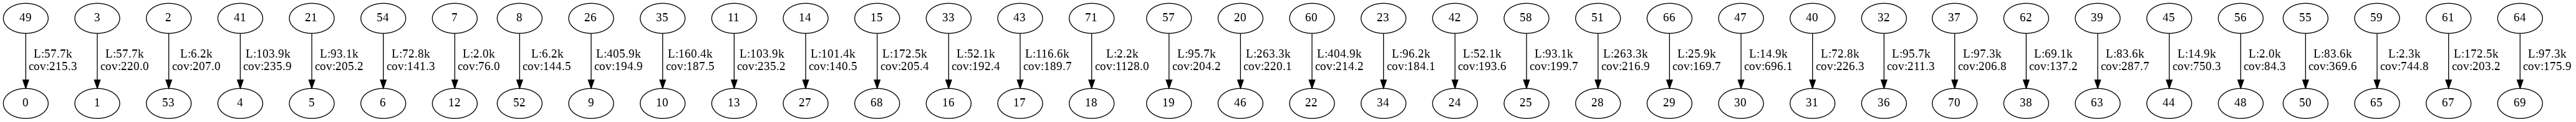

In [211]:
dbg.write_in_dot('new_100k_allbad.dot', 'new_100k_allbad.json')
dbg.dot_to_png('new_100k_allbad.dot', 'new_100k_allbad.png')
Image('new_100k_allbad.png')